## MSc Business Analytics & Management - Thesis - Data analysis

#### Authored by Benjamin Aston on 24/02/2025

### Randomisation of test cases

#### Packages

In [113]:
#Import packages
import pandas as pd
import numpy as np
import sqlite3
from skimpy import skim
from ydata_profiling import ProfileReport
import sweetviz as sv
from sklearn.preprocessing import StandardScaler
from scipy import stats
import matplotlib.pyplot as plt
import dowhy
from dowhy import CausalModel
import networkx as nx
from econml.grf import CausalForest
from skopt import gp_minimize
from skopt.space import Integer, Categorical
import os

#### Load config list and names of json requests

In [125]:
# # Connect to SQLite database
db_path = r"C:\Users\benja\Documents\MSC BAM\THESIS\Data\MSc BAM dummy data storage.sqlite"
conn = sqlite3.connect(db_path)

#Send the data to the db for intial configs
initial_data = pd.read_csv(r"C:\Users\benja\Documents\MSC BAM\THESIS\Gitrepo\CHATGPT - STARTERS PACKAGE\New synthetic data\Synthetic_data_with_Execution_Time_small.csv")
initial_data.to_sql("Synthetic_data", conn, if_exists="replace", index=False)
# # Read data from the SQLite database
Synthetic_data = pd.read_sql('SELECT * FROM Synthetic_data', conn)

# # Close the connection
conn.close()

,Configuration,DB_Memory,MAS_Workers,Parallel_Jobs,Execution_Time
0,Config 1,250,10,10,12022.231742
1,Config 2,250,10,20,12026.988130
2,Config 3,250,10,30,12077.817693
3,Config 4,250,10,40,12059.619862
4,Config 5,250,10,50,12116.673833
...,...,...,...,...,...
211,Config 212,2500,70,20,1657.257299
212,Config 213,2500,70,30,1674.148123
213,Config 214,2500,70,40,1712.228639
214,Config 215,2500,70,50,1705.512651


#### Phase 1

In [133]:
#How many initial phase 1 sample
percentage_tc_explored = 0.25 #config for user
n_phase1 = int(len(Synthetic_data.index)*percentage_tc_explored)

#Convert configurations_df to list
def col_to_list(column):
    config_list = Synthetic_data[column].tolist()
    return config_list
config_list = col_to_list("Configuration")

#Remove str config from config list and set as numeric
string = "Config "
for index,i in enumerate(config_list):
    config_list[index] = i.replace(string,'')
config_list = list(map(int,config_list))

#Assign test case to random configs
phase1_assignment = np.random.choice(config_list,size=n_phase1,replace=True)
print("The configurations to run are:", phase1_assignment)
phase_1_tcs_df = Synthetic_data[Synthetic_data.index.isin(phase1_assignment)]
phase_1_tcs_df.to_csv(r"C:\Users\benja\Documents\MSC BAM\THESIS\Gitrepo\CHATGPT - STARTERS PACKAGE\Random_Phase_1_Sampled_Data.csv",index=False)

# # Connect to SQLite database
# db_path = r"C:\Users\benja\Documents\MSC BAM\THESIS\Data\MSc BAM dummy data storage.sqlite"
# conn = sqlite3.connect(db_path)

# # Write data to SQLite database
# synthetic_data = pd.read_sql('SELECT * FROM Phase_1_synthetic_data', conn)

# # Close connection
# conn.close()

#Convert syn_df to list
def col_to_list(column):
    synthetic_data_list = synthetic_data[column].tolist()
    return synthetic_data_list
synthetic_data_list = col_to_list("Configuration")

#Remove config from config_list and set to numeric
string = "Config "
for index,i in enumerate(synthetic_data_list):
    synthetic_data_list[index] = i.replace(string,'')
synthetic_data_list = list(map(int,synthetic_data_list))
synthetic_data["Configuration"] = synthetic_data_list

#Phase 1 visualisation
plt.scatter(synthetic_data['Configuration'],synthetic_data['execution_time'],color='blue',label='Phase 1')
plt.xlabel("Configuration Index")
plt.ylabel("Execution Time")
plt.title("Execution time per configuration for same test case - Phase 1")
plt.legend()
plt.show()


The configurations to run are: [194  47 148  45  74 108  36 199  94 123 139  47  14  59 195 125 113 141
 212 209 202 201 182 165 141  31  71 127 167 127 164  17  66 113  39  88
  79  14 189 214 170  51  55 212 166 183  38 129  10 110 134  25 133  27]


AttributeError: 'int' object has no attribute 'replace'

#### Phase 2

#### Database connection

In [109]:
#Convert strings to categories
memory_categories = ["small","medium","large"]

#Set search space
space = [
    Integer(20,120,name='CPU Cores'),
    Categorical(memory_categories,name='System Memory'),
    Integer(20,120,name='MAS Workers'),
    Categorical(memory_categories,name='Database Memory')
                ]

#Objective function
def objective_function(params):
    cpu,memory,workers,db_memory=params

    row = synthetic_data[(synthetic_data['CPU Cores'] == cpu) &
            (synthetic_data['System Memory'] == memory) &
            (synthetic_data['MAS Workers'] == workers) &
            (synthetic_data['Database Memory'] == db_memory)]
    if not row.empty:
        return row["execution_time"].values[0]
    else:
        return 1e6

#Run optimisation
prev_best = float('inf')
tolerance = 0.01 #up to user to config

for i in range(10,50):
    res = gp_minimize(objective_function,space,n_calls=i,random_state=42)
    new_best = res.fun
    if (abs(prev_best - new_best) / prev_best) < tolerance:
        print(f"Stopping early at {i} iteration")
        break
    prev_best = new_best

#Extract optimal configurations
selected_configs = pd.DataFrame(res.x_iters,columns=['CPU Cores','System Memory','MAS Workers','Database Memory'])

# Precompute configuration probabilities
config_probs = synthetic_data["Configuration"].value_counts(normalize=True)

# def compute_IPW(row):
#     prob = config_probs.get(row["Configuration"], 1 / synthetic_data["Configuration"].nunique())
#     return 1 / prob

# # # # Apply the corrected IPW function
# selected_configs['IPW_Score'] = selected_configs.apply(compute_IPW, axis=1)

# # Verify results
# print(selected_configs[IPW_Score].head())

# #Send to CSV
# conn = sqlite3.connect(db_path)
# cursor = conn.cursor()
# selected_configs.to_sql('Final_output_synthetic_data', conn, if_exists='replace', index=False)
# conn.commit()
# conn.close()

C:\Users\benja\AppData\Local\Temp\ipykernel_8036\2746772536.py:32: RuntimeWarning: invalid value encountered in scalar divide
  if (abs(prev_best - new_best) / prev_best) < tolerance:


Stopping early at 11 iteration


Configuration
78     0.018519
108    0.018519
45     0.018519
89     0.018519
90     0.018519
10     0.018519
34     0.018519
56     0.018519
104    0.018519
29     0.018519
41     0.018519
6      0.018519
54     0.018519
40     0.018519
11     0.018519
36     0.018519
17     0.018519
79     0.018519
35     0.018519
67     0.018519
8      0.018519
44     0.018519
66     0.018519
73     0.018519
28     0.018519
20     0.018519
16     0.018519
101    0.018519
48     0.018519
32     0.018519
5      0.018519
84     0.018519
63     0.018519
68     0.018519
31     0.018519
46     0.018519
96     0.018519
12     0.018519
82     0.018519
80     0.018519
1      0.018519
81     0.018519
19     0.018519
70     0.018519
57     0.018519
77     0.018519
107    0.018519
43     0.018519
13     0.018519
37     0.018519
65     0.018519
27     0.018519
23     0.018519
91     0.018519
Name: proportion, dtype: float64

In [ ]:
# Read data from SQLite table
conn = sqlite3.connect(db_path)
cursor = conn.cursor()
query = "SELECT * FROM Final_output_synthetic_data"
Final_output_synthetic_data = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

#Print data 
Final_output_synthetic_data.head(10)


#### Descriptives

In [ ]:
#Dummy setting of variables
Final_output_synthetic_data = pd.get_dummies(Synthetic_data, columns=["System Memory", "Database Memory"], drop_first=True)

In [ ]:
#Summarise with skimpy
skim(Final_output_synthetic_data)

#Create report
profile = ProfileReport(Final_output_synthetic_data, title="Synthetic_data Profiling Report", explorative=True)

# Save the report as an HTML file
profile.to_file("Final_output_synthetic_data_profile_report.html")

#Use sweetviz for more summary reports
report = sv.analyze(Final_output_synthetic_data)
report.show_html("Final_output_synthetic_data_sweetviz_report.html")


#### Cleaning leading and na's

In [ ]:
# Remove leading and trailing whitespaces from values
Final_output_synthetic_data.columns = Final_output_synthetic_data.columns.str.strip()

#Count NAs in columns
for col in Final_output_synthetic_data.columns:
    na_count = Final_output_synthetic_data[col].isna().sum()
    print(f"Missing values in {col}: {na_count}")

#No missings, if there are any in the future, they need to be tackled


#### Outliers and scaling

In [107]:
#Category defined
# Final_output_synthetic_data['Database Memory'] = Final_output_synthetic_data['Database Memory'].astype('category')
# Final_output_synthetic_data['System Memory'] = Final_output_synthetic_data['System Memory'].astype('category')

# #Scale variables
# #Cols to not scale
# No_scale = ["Configuration","execution_time","Database Memory","System Memory"]

# # Scale it into the same df
# columns_to_scale = [col for col in Final_output_synthetic_data.columns if col not in No_scale]

# # Initialize the scaler
# scaler = StandardScaler()
# Final_output_synthetic_data[columns_to_scale] = scaler.fit_transform(Final_output_synthetic_data[columns_to_scale])

#### Causal analysis set up

#### DoWhy analysis

In [131]:
common_causes = ["CPU Cores", "MAS Workers"] + \
    [col for col in Final_output_synthetic_data.columns if "System Memory" in col or "Database Memory" in col]

model = CausalModel(
    data=Final_output_synthetic_data,
    treatment="treatment",
    outcome="execution_Time",
    common_causes=common_causes
)

C:\Users\benja\anaconda3\Lib\site-packages\dowhy\causal_model.py:583: UserWarning: 2 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


#### Show DAG based on set up

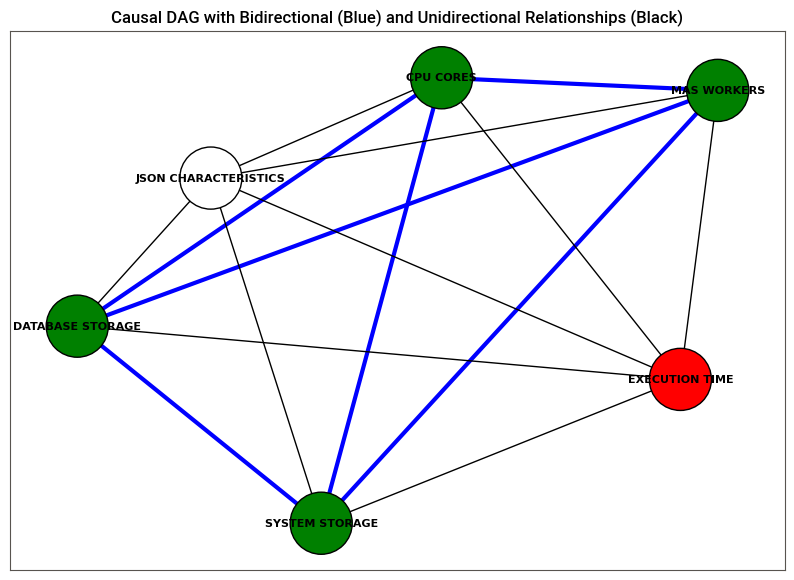

In [133]:
# Create a Directed Graph
G = nx.DiGraph()

# Define bidirectional relationships (single thick blue arrows with two heads)
edges_bidirectional = [
    ('CPU CORES', 'SYSTEM STORAGE'),
    ('CPU CORES', 'DATABASE STORAGE'),
    ('MAS WORKERS', 'DATABASE STORAGE'),
    ('MAS WORKERS', 'SYSTEM STORAGE'),
    ('DATABASE STORAGE', 'SYSTEM STORAGE'),
    ('MAS WORKERS', 'CPU CORES')
]

# Define unidirectional relationships (single thin black arrows)
edges_unidirectional = [
    ('CPU CORES', 'EXECUTION TIME'),
    ('SYSTEM STORAGE', 'EXECUTION TIME'),
    ('DATABASE STORAGE', 'EXECUTION TIME'),
    ('MAS WORKERS', 'EXECUTION TIME'),
    ('JSON CHARACTERISTICS', 'EXECUTION TIME'),
    ('JSON CHARACTERISTICS', 'MAS WORKERS'),
    ('JSON CHARACTERISTICS', 'SYSTEM STORAGE'),
    ('JSON CHARACTERISTICS', 'CPU CORES'),
    ('JSON CHARACTERISTICS', 'DATABASE STORAGE')
]

# Add unidirectional edges to the graph
G.add_edges_from(edges_unidirectional)

# Generate a position layout
pos = nx.spring_layout(G, seed=42)

# Assign colors: Red for 'Execution Time', White for 'JSON CHARACTERISTICS', Green for others
node_colors = {
    "EXECUTION TIME": "red",
    "JSON CHARACTERISTICS": "white"
}
default_color = "green"
node_color_list = [node_colors.get(node, default_color) for node in G.nodes()]

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 7))

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color=node_color_list, edgecolors="black", node_size=2000, ax=ax)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=8, font_weight="bold", ax=ax)

# Draw bidirectional edges as a single thick blue line with two arrowheads
for a, b in edges_bidirectional:
    nx.draw_networkx_edges(G, pos, edgelist=[(a, b)], edge_color="blue", width=3, ax=ax, arrows=True, arrowstyle='<->')

# Draw unidirectional edges as thin black arrows
nx.draw_networkx_edges(G, pos, edgelist=edges_unidirectional, edge_color="black", width=1, ax=ax, arrows=True)

# Set title
plt.title("Causal DAG with Bidirectional (Blue) and Unidirectional Relationships (Black)", fontsize=12)

# Save the figure before calling plt.show()
plt.savefig("Causal Dag.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

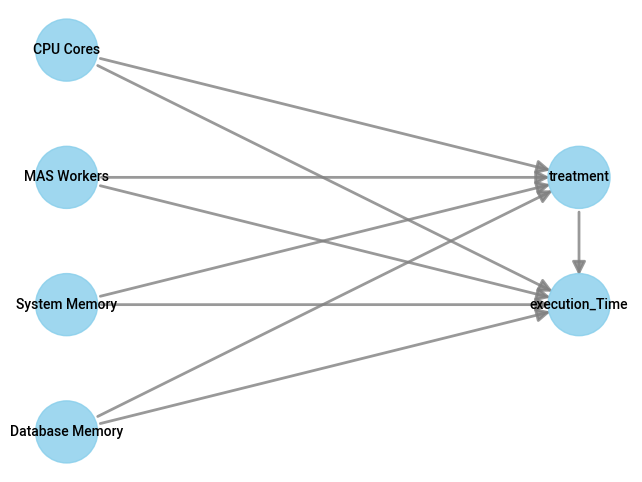

In [135]:
# Visualize the assumed causal graph
model.view_model()

### Causal forest

#### Test train split

#### Set up estimates

In [ ]:
# Identify the causal effect using a backdoor adjustment
identified_estimand = model.identify_effect()
print("Identified estimand: \n", identified_estimand)

In [ ]:
# Define feature matrix (all configuration variables)
features = data[common_causes]
treatment = data["treatment"]
outcome = data["Execution_Time"]

In [ ]:
# Instantiate and fit the Causal Forest model
cf = CausalForest(random_state=123)
cf.fit(features.values, outcome.values, treatment.values)

In [ ]:
# Predict the Conditional Average Treatment Effect (CATE) for each observation
data["CATE"] = cf.predict(features.values)
print(data[["CATE"]].head())

In [ ]:
# Plot the distribution of the estimated CATEs
plt.hist(data["CATE"], bins=30, edgecolor="k")
plt.xlabel("Estimated CATE")
plt.ylabel("Frequency")
plt.title("Distribution of Estimated Conditional Average Treatment Effects")
plt.show()

### Bayesian optimisation

### Bayesian NN

#### Order sampling to ID dag